In [1]:
# Jia-luen Yang

import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import textwrap
from langdetect import detect
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/allen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/allen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
num_of_files = len(os.listdir('JSON'))

df_list = []

for i in range(1, num_of_files + 1):
    json_file_path = 'JSON/' + str(i) + '.json'

    with open(json_file_path, 'r') as file:
        json_data = json.load(file)
        data = json_data['data']

    df_list.append(pd.DataFrame(data))

df = pd.concat(df_list, ignore_index=True)


# Remove non-English reviews
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# df['language'] = df['body'].apply(detect_language)
# test = df[df['language'] != 'en']
# for index, row in test.iterrows():
#     print(row['body'])
# df = df[df['language'] == 'en']
# df.drop(columns=['language'], inplace=True)

### Data Distribution

In [3]:
print("Number of AI-assisted human reviews: ", (df['isAI'] == 2).sum())

df.loc[df['isAI'] == 2, 'isAI'] = 1

Number of AI-assisted human reviews:  145


In [4]:
print("Number of AI reviews:     ", (df['isAI'] == 1).sum())
print("Number of human reviews:  ", (df['isAI'] == 0).sum())
print("Total number of reviews:  ", len(df))
print("Percentage of AI reviews:  {:.2f}%".format((df['isAI'] == 1).sum()/len(df) * 100))

Number of AI reviews:      1116
Number of human reviews:   5101
Total number of reviews:   6217
Percentage of AI reviews:  17.95%


In [5]:
temp_df = df[df['hasImage'] == 1].copy()
print("Percentage of AI reviews given the review has photos:  {:.2f}%".format((temp_df['isAI'] == 0).sum() / len(temp_df) * 100))

temp_df = df[df['hasVideo'] == 1].copy()
print("Percentage of AI reviews given the review has a video: {:.2f}%".format((temp_df['isAI'] == 0).sum() / len(temp_df) * 100))

Percentage of AI reviews given the review has photos:  79.89%
Percentage of AI reviews given the review has a video: 70.15%


In [6]:
X_train,X_test,y_train,y_test=train_test_split(df['body'],df['isAI'],test_size=0.3, stratify=df['isAI'], random_state=42)

In [7]:
pipeMNB = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('clf',MultinomialNB())])
pipeLogReg = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('clf',LogisticRegression())])
pipeCNB = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('clf',ComplementNB())])
pipeSVC = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('clf',LinearSVC())])

pipeMNB.fit(X_train,y_train)
pipeLogReg.fit(X_train,y_train)
pipeCNB.fit(X_train,y_train)
pipeSVC.fit(X_train,y_train)

predictMNB = pipeMNB.predict(X_test)
predictLogReg = pipeLogReg.predict(X_test)
predictCNB = pipeCNB.predict(X_test)
predictCSV = pipeSVC.predict(X_test)

mnb = accuracy_score(y_test,predictMNB)
lg = accuracy_score(y_test,predictLogReg)
cnb = accuracy_score(y_test,predictCNB)
svc = accuracy_score(y_test,predictCSV)

print(f"MNB: {mnb*100:.2f}%")
print(f"LG:  {lg*100:.2f}%")
print(f"CNB: {cnb*100:.2f}%")
print(f"SVC: {svc*100:.2f}%")

/Users/allen/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


MNB: 93.52%
LG:  97.32%
CNB: 96.73%
SVC: 99.25%


In [8]:
print("Classification Report for Multinomial Naive Bayes:")
print(classification_report(y_test, predictMNB, digits=4))

Classification Report for Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0     0.9268    1.0000    0.9620      1531
           1     1.0000    0.6388    0.7796       335

    accuracy                         0.9352      1866
   macro avg     0.9634    0.8194    0.8708      1866
weighted avg     0.9399    0.9352    0.9292      1866



In [9]:
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, predictLogReg, digits=4))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0     0.9684    1.0000    0.9839      1531
           1     1.0000    0.8507    0.9194       335

    accuracy                         0.9732      1866
   macro avg     0.9842    0.9254    0.9516      1866
weighted avg     0.9741    0.9732    0.9723      1866



In [10]:
print("Classification Report for Complement Naive Bayes:")
print(classification_report(y_test, predictCNB, digits=4))

Classification Report for Complement Naive Bayes:
              precision    recall  f1-score   support

           0     0.9688    0.9922    0.9803      1531
           1     0.9597    0.8537    0.9036       335

    accuracy                         0.9673      1866
   macro avg     0.9642    0.9229    0.9420      1866
weighted avg     0.9671    0.9673    0.9665      1866



In [11]:
print("Classification Report for Support Vector Classifier:")
print(classification_report(y_test, predictCSV, digits=4))

Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0     0.9916    0.9993    0.9954      1531
           1     0.9969    0.9612    0.9787       335

    accuracy                         0.9925      1866
   macro avg     0.9942    0.9803    0.9871      1866
weighted avg     0.9925    0.9925    0.9924      1866



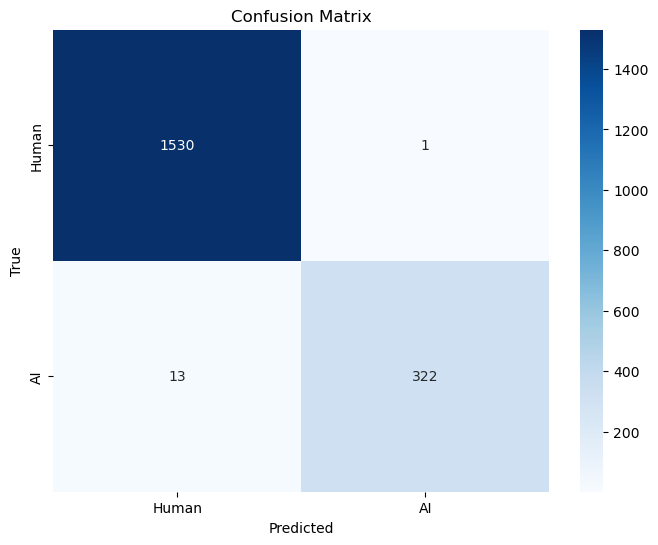

In [12]:
def plot_confustion_matrix(conf_matrix):
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictCSV)
plot_confustion_matrix(conf_matrix)

In [13]:
data = {'X_test': X_test, 'y_test': y_test, 'y_pred': predictCSV}
temp_df = pd.DataFrame(data)

# Filter the DataFrame to get the desired rows
filtered_df = temp_df[(temp_df['y_test'] == 1) & (temp_df['y_pred'] == 0)]

# Display the texts from X_test where y_test = 1 and y_pred = 0
texts_where_mismatch = filtered_df['X_test'].tolist()

print("False Negatives:")
print("===========================\n")

# Iterate over each text and print it with word wrap
for text in texts_where_mismatch:
    wrapped_text = textwrap.fill(text, width=130)  # Adjust width as needed
    print(wrapped_text)
    print('\n')


False Negatives:

I've been using this weekly planner pad for my desk, and it's been amazing for keeping me organized both at work and at home. The
multiple sections help me stay on track each week, with dedicated spaces for top priorities, to-do lists, and daily plans for both
weekdays and weekend. The pad is designed with easy tear-off pages, which is convenient when moving on to a new week. I
particularly like the notes section, which comes in handy for jotting down important information. The size is perfect for my desk,
and the layout provides enough space to plan out the week effectively. Overall, this weekly planner pad has become an essential
tool for me, and I highly recommend it to anyone looking to stay organized and on top of their schedule weekly.


I just got the Razer DeathAdder Essential Gaming Mouse, and I really like it for my gaming setup.  First off, it feels good in my
hand. The design is simple but comfy, and the textured grips on the sides keep it from slipping du

In [14]:
# Filter the DataFrame to get the desired rows
filtered_df = temp_df[(temp_df['y_test'] == 0) & (temp_df['y_pred'] == 1)]

# Display the texts from X_test where y_test = 1 and y_pred = 0
texts_where_mismatch = filtered_df['X_test'].tolist()

print("False Positives:")
print("===========================\n")

# Iterate over each text and print it with word wrap
for text in texts_where_mismatch:
    wrapped_text = textwrap.fill(text, width=130)  # Adjust width as needed
    print(wrapped_text)
    print('\n')

False Positives:

Must have for my daily makeup routine. 4 stars only because I'm looking for a powder that makes me young again. Until then, I'll
use this guy.




In [15]:
# text = "I recently added the Lenovo Legion Go to my handheld gaming collection, and it has truly surpassed my expectations. As an owner of both the Lenovo Legion Go and the Steam Deck, I can confidently say that the Legion Go offers a superior gaming experience.  Build Quality: The Legion Go's sleek and sturdy design stands out, providing a premium feel compared to the Steam Deck. The ergonomic design ensures comfortable gaming sessions, and the build quality feels robust and durable.  Performance: The Legion Go outshines the Steam Deck in terms of performance. The seamless gameplay, powered by its impressive hardware, delivers smooth graphics and quick response times. It's evident that Lenovo has prioritized performance for an unparalleled gaming experience.  Display Quality: The Legion Go boasts a vibrant and crisp display, making games come to life with stunning visuals. When compared to the Steam Deck, the Legion Go's display stands out, offering better color accuracy and clarity, enhancing the overall gaming immersion.  Battery Life: Lenovo Legion Go impresses with its extended battery life, providing longer gaming sessions compared to the Steam Deck. This is a game-changer for on-the-go gaming enthusiasts, ensuring uninterrupted gameplay without the need for frequent recharging.  Customization and User Interface: Lenovo's commitment to user-friendly interfaces and customization options gives the Legion Go a significant edge. Navigating through menus and adjusting settings is intuitive, making it a breeze to personalize the gaming experience according to individual preferences.  In conclusion, as a proud owner of both handhelds, the Lenovo Legion Go has become my go-to device for immersive gaming sessions. Its superior build quality, unmatched performance, impressive display, extended battery life, and user-friendly interface make it a clear winner over the Steam Deck. If you're looking for the ultimate handheld gaming experience, the Legion Go is the way to go!"

# print(pipeSVC.predict([text]))

In [16]:
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
linking_words = {'to', 'the', 'and', 'of', 'in', 'on', 'for', 'with', 'at', 'a', 'an'}

# Function to count the length of each text and perform sentiment analysis
def analyze_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in linking_words]
    tokens = [token for token in tokens if token.isalpha()]
    # Sentiment analysis
    blob = TextBlob(text)
    sentiment_scores = [sentence.sentiment.polarity for sentence in blob.sentences]
    negative_count = sum(1 for score in sentiment_scores if score < 0)
    return len(tokens), negative_count


new_df = df[['body', 'isAI']].copy()
new_df[['token_length', 'neg_sentiment_sentence_count']] = new_df['body'].apply(lambda x: pd.Series(analyze_text(x)))
new_df['token_length'] = new_df['token_length'].astype(int)

/Users/allen/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/allen/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/allen/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/allen/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LG:  96.25%
SVC: 98.82%


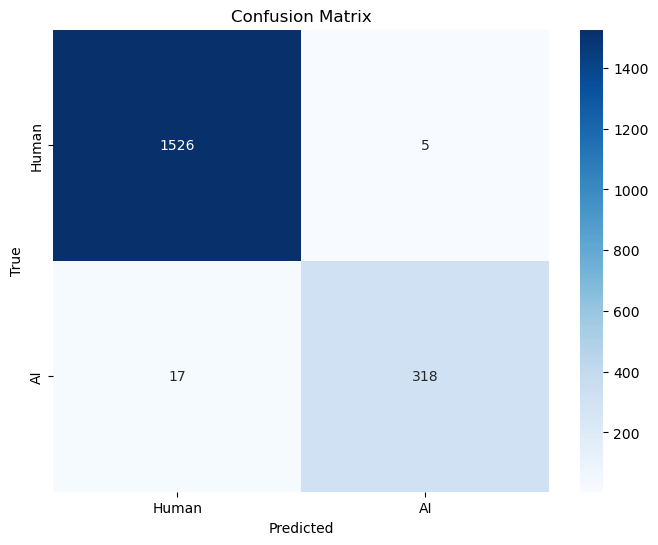

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = new_df[['body', 'token_length', 'neg_sentiment_sentence_count']]
y = new_df[['isAI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Column transformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'body'),
        ('numerical', StandardScaler(), ['token_length', 'neg_sentiment_sentence_count'])
    ],
    remainder='passthrough'  # Pass through any remaining columns as they are
)

# Creating the pipeline with preprocessing and model
pipeLogReg = make_pipeline(preprocessor, LogisticRegression())
pipeSVC = make_pipeline(preprocessor, LinearSVC())

# Fitting the pipeline to the training data
pipeLogReg.fit(X_train,y_train)
pipeSVC.fit(X_train,y_train)

# Make predictions
predictLogReg = pipeLogReg.predict(X_test)
predictCSV = pipeSVC.predict(X_test)

lg = accuracy_score(y_test,predictLogReg)
svc = accuracy_score(y_test,predictCSV)

print(f"LG:  {lg*100:.2f}%")
print(f"SVC: {svc*100:.2f}%")

conf_matrix = confusion_matrix(y_test, predictCSV)
plot_confustion_matrix(conf_matrix)